In [ ]:
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 50.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 34.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 102.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 81.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 36.4 MB/s eta 0:00:00


In [ ]:
import random
from collections import defaultdict
import matplotlib.pyplot as plt
from textwrap import wrap
import pandas as pd
import numpy as np
import seaborn as sns
import torch
import os

from matplotlib import rc
from pylab import rcParams
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from transformers import (
    AdamW,
    BertModel,
    BertTokenizer,
    get_linear_schedule_with_warmup,
)

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [ ]:
# Set color palette for plots
color = lambda: random.randint(0, 255)
colors = ['#%02X%02X%02X' %(color(), color(), color()) for i in range(6)]
sns.set_palette(sns.color_palette(colors))
rcParams['figure.figsize'] = 12, 10

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
torch.manual_seed(RANDOM_STATE)

# Check if cuda is enabled in the device
device = torch.cuda.is_available()

if not device:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is not available.  Training on CPU ...


In [ ]:
MODEL = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(MODEL, do_lower_case=True)

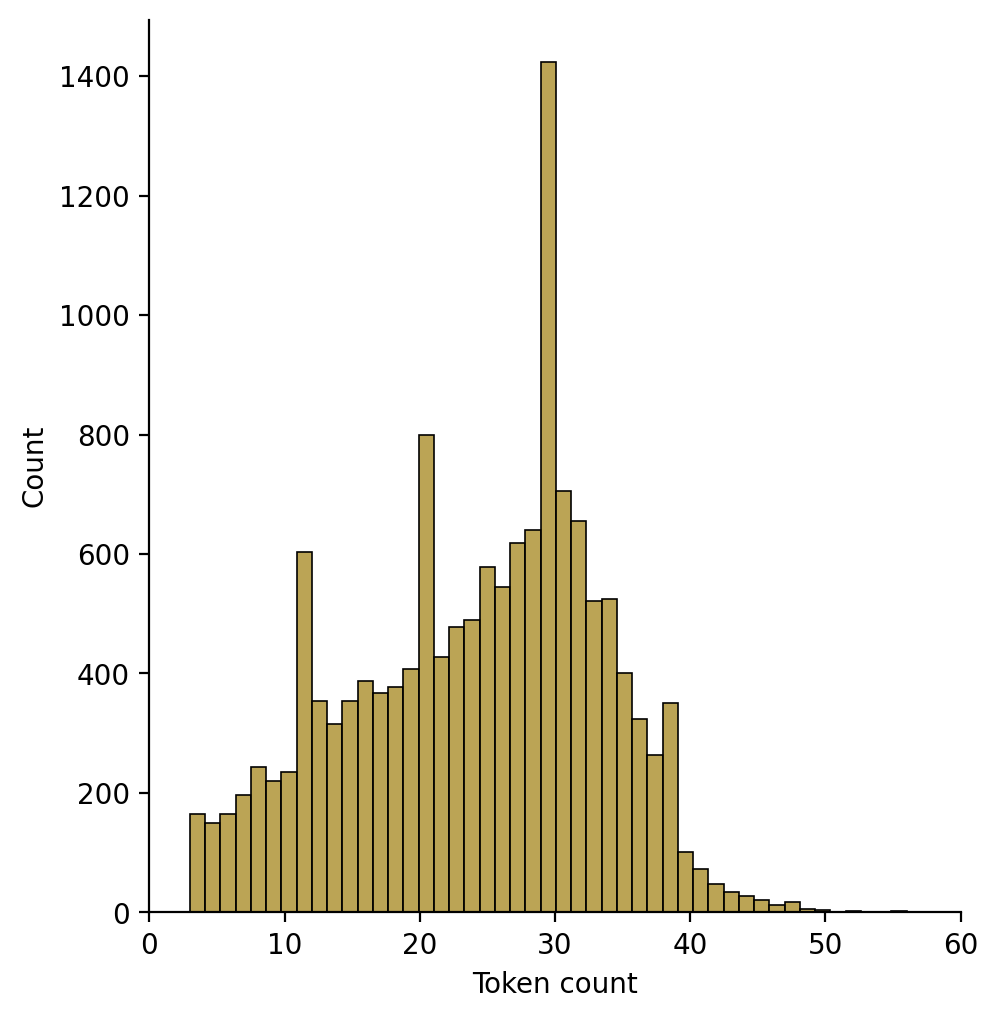

In [ ]:
tokens = [len(tokenizer.encode(text, max_length=512, truncation=True)) for text in df.text]
sns.displot(tokens)
plt.xlim([0, 60]);
plt.xlabel('Token count');

In [ ]:
from torch.utils.data import Dataset, DataLoader

# Define a custom dataset, more info on how to build custom dataset can be
# found at https://pytorch.org/tutorials/beginner/data_loading_tutorial.html
class CustomDataset(Dataset):

    def __init__(
        self,
        tweets,
        labels,
        tokenizer,
        max_length
    ):
        self.tweets = tweets
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.tweets)

    def __getitem__(self, idx):
        tweet = self.tweets[idx]
        label = self.labels[idx]

        tokenize = self.tokenizer.encode_plus(
            tweet,
            add_special_tokens=True,
            max_length=self.max_length,
            return_token_type_ids=False,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt'
        )
        return {
            'tweet': tweet,
            'input_ids': tokenize['input_ids'].flatten(),
            'attention_mask': tokenize['attention_mask'].flatten(),
            'targets': torch.tensor(label, dtype=torch.long)}

In [ ]:
MAX_LENGTH = 64
TEST_SIZE = 0.1
VALID_SIZE = 0.5
BATCH_SIZE = 16
NUM_WORKERS = 2

train_sampler, test_sampler = train_test_split(df, test_size=TEST_SIZE, random_state=RANDOM_STATE)
valid_sampler, test_sampler = train_test_split(test_sampler, test_size=VALID_SIZE, random_state=RANDOM_STATE)

train_set = CustomDataset(
    train_sampler['text'].to_numpy(),
    train_sampler['labels'].to_numpy(),
    tokenizer,
    MAX_LENGTH
)
test_set = CustomDataset(
    test_sampler['text'].to_numpy(),
    test_sampler['labels'].to_numpy(),
    tokenizer,
    MAX_LENGTH
)
valid_set = CustomDataset(
    valid_sampler['text'].to_numpy(),
    valid_sampler['labels'].to_numpy(),
    tokenizer,
    MAX_LENGTH
)

train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS)
valid_loader = DataLoader(valid_set, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS)

In [ ]:
from torch import nn
class AirlineSentimentClassifier(nn.Module):

    def __init__(self, num_labels):
        super (AirlineSentimentClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(MODEL)
        self.dropout = nn.Dropout(p=0.2)
        self.classifier = nn.Linear(self.bert.config.hidden_size, num_labels)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        pooled_output = outputs[1]
        pooled_output = self.dropout(pooled_output)
        out = self.classifier(pooled_output)
        return out


In [ ]:
model = AirlineSentimentClassifier(len(labels_map))
print(model)

# Move tensors to GPU on CUDA enables devices
if device:
    model.cuda()

AirlineSentimentClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, el

In [ ]:
n_epochs = 10
learning_rate =2e-5

# Loss function
criterion = nn.CrossEntropyLoss()

# Optimizer
optimizer = AdamW(model.parameters(), lr=learning_rate, correct_bias=False)

# Define scheduler
training_steps = len(train_loader)*n_epochs
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=training_steps
)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
input_ids = data["input_ids"]
attention_mask = data["attention_mask"]
targets = data["targets"]

# Check if a CUDA-compatible GPU is available
if torch.cuda.is_available():
    # Send tensors to GPU
    input_ids = input_ids.cuda()
    attention_mask = attention_mask.cuda()
    targets = targets.cuda()


In [ ]:
# Track changes in validation loss
valid_loss_min = np.Inf

for epoch in range(1, n_epochs+1):

    # Setting training and validation loss
    train_loss = []
    validation_loss = []
    tr_predictions = 0
    acc = 0
    val_predictions = 0

    ####################
    #  Train the model #
    ####################
    model = model.train()
    for data in train_loader:

        # Moving tensors to GPU on CUDA enabled devices
        if device:
            input_ids, attention_mask, targets = data["input_ids"].cuda(), data["attention_mask"].cuda(), data["targets"].cuda()
        # Clear the gradients of variables
        optimizer.zero_grad()

        #### Forward pass
        # Pass input through the model
        output = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        # Compute batch loss
        loss = criterion(output, targets)
        # Convert output probabilities to class probabilities
        _, pred = torch.max(output, 1)
        # Track correct predictions
        tr_predictions += torch.sum(pred == targets)

        #### Backward Pass
        # Compute gradients wrt to model parameters
        loss.backward()
        # To avoid exploding gradients, we clip the gradients of the model
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        # Perform parameter update
        optimizer.step()
        # Update learning rate
        scheduler.step()
        # Update loss per mini batches
        train_loss.append(loss.item())

    ######################
    # Validate the model #
    ######################
    model.eval()
    with torch.no_grad():
        for data in valid_loader:

            # Moving tensors to GPU on CUDA enabled devices
            if device:
                input_ids, attention_mask, targets = data["input_ids"].cuda(), data["attention_mask"].cuda(), data["targets"].cuda()

            #### Forward pass
            # Pass input through the model
            output = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            # Compute batch loss
            loss = criterion(output, targets)
            # Convert output probabilities to class probabilities
            _, pred = torch.max(output, 1)
            # Update loss per mini batches
            validation_loss.append(loss.item())
            # Track correct predictions
            val_predictions += torch.sum(pred == targets)

    # Compute accuracy
    train_accuracy = tr_predictions.double()/len(train_sampler)
    val_accuracy = val_predictions.double()/len(valid_sampler)

    # Print loss statistics
    print('Epoch: {}/{} \n\tTraining Loss: {:.6f} \n\tValidation Loss: {:.6f} \n\tTrain Accuracy: {:.6f} \n\tVal Accuracy: {:.6f}'.format(epoch,n_epochs, np.mean(train_loss), np.mean(validation_loss), train_accuracy, val_accuracy))

    # Save model if validation loss is decreased
    if val_accuracy > acc:
        print('Saving model...')
        torch.save(model.state_dict(), 'bert_base_fine_tuned.pt')
        acc = val_accuracy


Epoch: 1/10
Training Loss: 0.478485
Validation Loss: 0.426510
Train Accuracy: 0.813221
Val Accuracy: 0.848361
Saving model...
Epoch: 2/10
Training Loss: 0.251598
Validation Loss: 0.587404
Train Accuracy: 0.912720
Val Accuracy: 0.837432
Saving model...
Epoch: 3/10 
    Training Loss: 0.147462 
    Validation Loss: 0.694001 
    Train Accuracy: 0.958333 
    Val Accuracy: 0.848361
    Saving model...
Epoch: 4/10 
    Training Loss: 0.095958 
    Validation Loss: 0.852052 
    Train Accuracy: 0.976548 
    Val Accuracy: 0.841530
    Saving model...
Epoch: 5/10 
    Training Loss: 0.062927 
    Validation Loss: 0.967488 
    Train Accuracy: 0.985504 
    Val Accuracy: 0.842896
    Saving model...
Epoch: 6/10 
    Training Loss: 0.042360 
    Validation Loss: 1.066000 
    Train Accuracy: 0.990437 
    Val Accuracy: 0.840164
    Saving model...
Epoch: 7/10 
    Training Loss: 0.032142 
    Validation Loss: 1.132496 
    Train Accuracy: 0.992410 
    Val Accuracy: 0.833333
    Saving model..

In [ ]:
# Track test loss
test_loss = 0.0
class_predictions = list(0. for i in range(3))
class_total = list(0. for i in range(3))
predictions = []
labels = []

model.eval()
with torch.no_grad():
    for data in test_loader:

        # Moving tensors to GPU on CUDA enabled devices
        if device:
            input_ids, attention_mask, targets = data["input_ids"].cuda(), data["attention_mask"].cuda(), data["targets"].cuda()

        #### Forward pass
        # Pass input through the model
        output = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        # Compute batch loss
        loss = criterion(output, targets)
        # Update loss
        test_loss += loss.item()
        # convert output probabilities to predicted class
        _, pred = torch.max(output, 1)

        predictions.extend(pred)
        labels.extend(targets)

predictions = torch.stack(predictions) if not device else torch.stack(predictions).cpu()
labels = torch.stack(labels) if not device else torch.stack(labels).cpu()

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(predictions, labels, target_names=['neutral', 'positive','negative']))





              precision    recall  f1-score   support

     neutral       0.68      0.71      0.69       146
    positive       0.79      0.81      0.80       118
    negative       0.92      0.90      0.91       468

    accuracy                           0.85       732
   macro avg       0.79      0.81      0.80       732
weighted avg       0.85      0.85      0.85       732



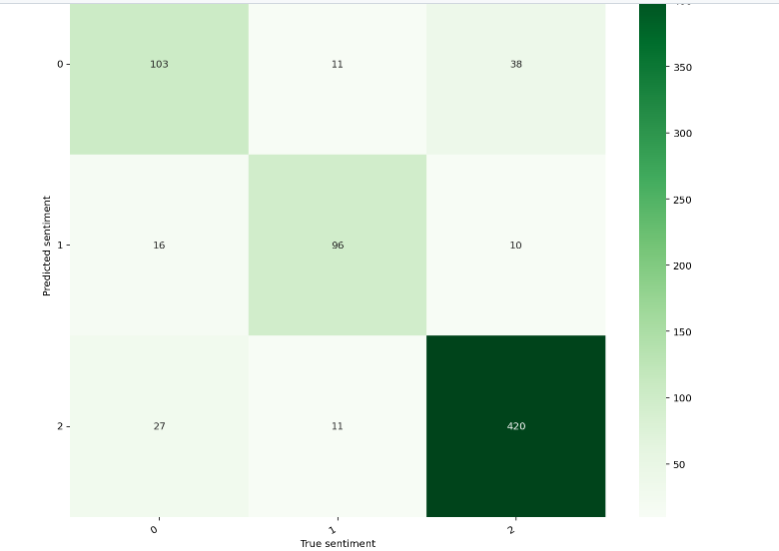

In [1]:
cm = confusion_matrix(labels, predictions)
heatmap = sns.heatmap(cm, annot=True, fmt='d', cmap='Greens')
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right')
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=30, ha='right')
plt.xlabel('True sentiment')
plt.ylabel('Predicted sentiment');


In [ ]:
from google.colab import drive
drive.mount('/content/drive')